In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [10]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [12]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [15]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).one()
print(most_recent_date)

('2017-08-23',)


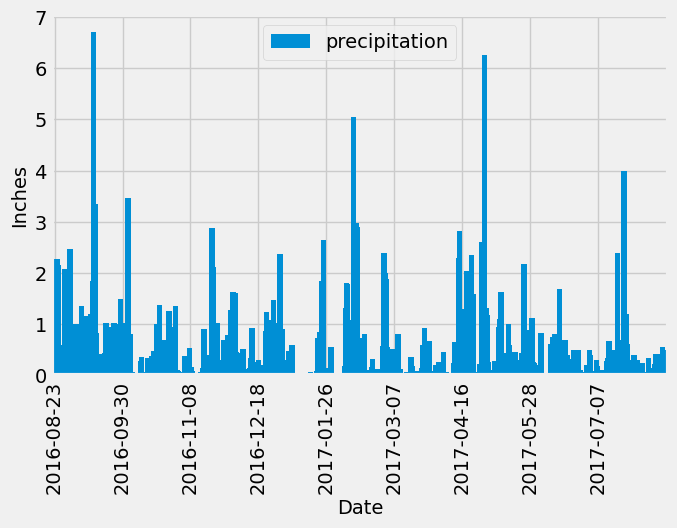

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date_ = dt.date.fromisoformat(most_recent_date[0])

# Calculate the date one year from the last date in data set.
one_year_date = date_ - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rec = session.query(Measurement.date, Measurement.prcp) \
             .filter(Measurement.date >= str(one_year_date)) \
             .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(rec, columns=['Date', 'precipitation']).set_index('Date')

# Sort the dataframe by date
df = df.sort_values(by=['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar(figsize=(7,5.5)
            ,width=20
            ,ylabel='Inches'
            ,rot='vertical')

plt.locator_params(axis='x', tight=True, nbins=9)
plt.tight_layout()
plt.show()

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()
total_stations

9

In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
                              .group_by(Measurement.station) \
                              .order_by(func.count(Measurement.station).desc()) \
                              .all() 
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
rec = session.query(func.min(Measurement.tobs) \
                    ,func.max(Measurement.tobs) \
                    ,func.avg(Measurement.tobs)) \
              .filter(Measurement.station == most_active_stations[0][0]) \
              .group_by(Measurement.station) \
              .order_by(func.count(Measurement.station).desc()) \
              .all() 
rec

[(54.0, 85.0, 71.66378066378067)]

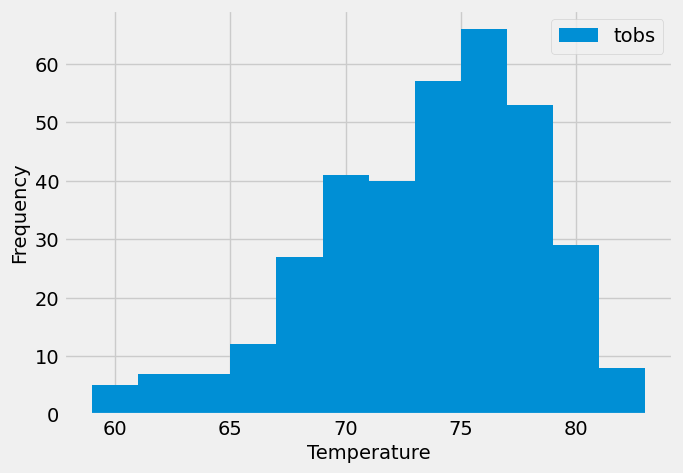

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
rec = session.query(Measurement.tobs) \
              .filter(Measurement.station == most_active_stations[0][0] 
                     ,Measurement.date >= str(one_year_date)) \
              .order_by(Measurement.tobs) \
              .all() 

df = pd.DataFrame(rec, columns=['tobs'])
df.head()

df.plot.hist(figsize=(7,5)
            ,ylabel='Frequency'
            ,bins=12
            ,width=2)

plt.xlabel('Temperature')

plt.show()

# Close Session

In [22]:
# Close Session
session.close()